<a href="https://colab.research.google.com/github/supercurlyman/praktikum.yandex/blob/master/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выпускной проект

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**  

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

%matplotlib inline


## Изучение данных

### Данные об электродах

In [ ]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()
data_arc.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [ ]:
data_arc[data_arc['Реактивная мощность'] < 0]['Реактивная мощность']

9780   -715.504924
Name: Реактивная мощность, dtype: float64

In [ ]:
len(data_arc['key'].unique())

3214

In [ ]:
data_arc.tail(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14866,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.411601,0.274390
14867,3240,2019-09-01 02:40:55,2019-09-01 02:43:28,0.521811,0.378517
14868,3240,2019-09-01 03:08:38,2019-09-01 03:11:08,0.518065,0.528780
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.983723,0.884585
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


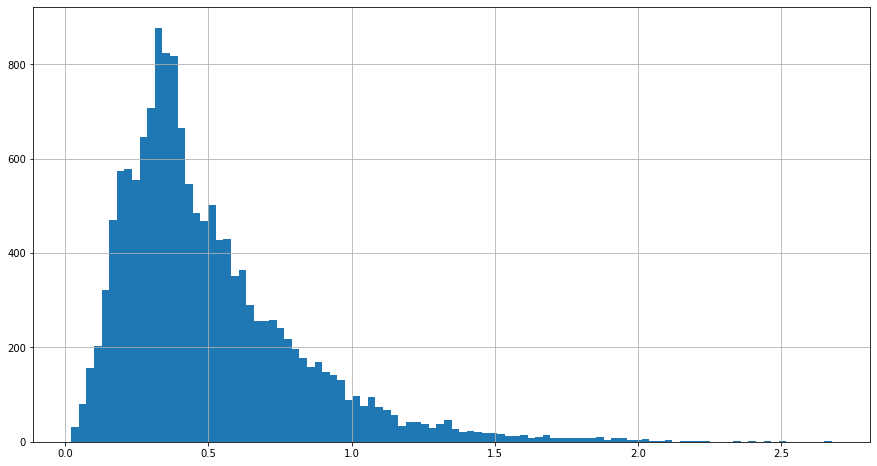

In [ ]:
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, figsize=(15,8))

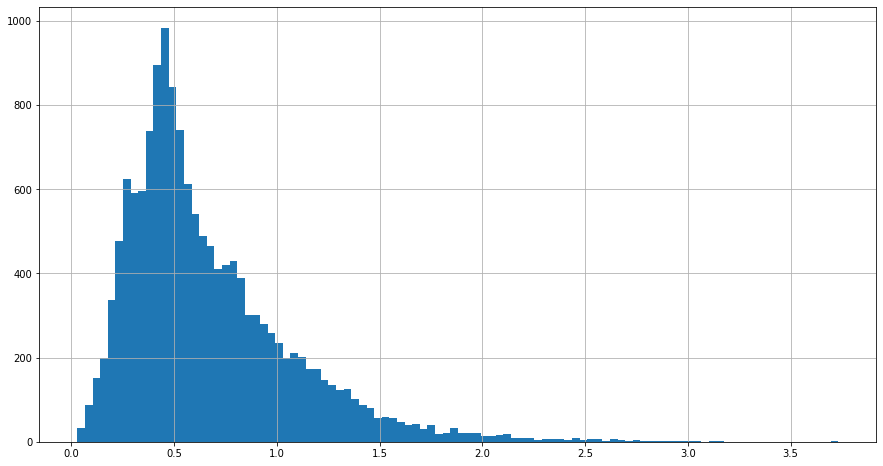

In [ ]:
data_arc['Активная мощность'].hist(bins=100, figsize=(15,8))

Есть аномалия в данных по реактивной мощности  
Время в формат object перевести в datetime  
Данные активной и реактивной мощности смещенны влево  

### Данные о подаче сыпучих материалов (объём)

In [ ]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()
data_bulk.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [ ]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [ ]:
len(data_bulk['key'].unique())

3129

Столбец key перевезти в целочисленный формат  
Имеется большие пропуски данных, скорее всего это связано с добавлением различного количество сыпучих материалов в смеси, в том числе и не добавлением, возможно это и ошибки датчика, но данные восстановить корректно невозможно.  
Данные перевезти из Float в int
Есть пропуски по ключам, возможно данные потерянны.


### Данные о подаче сыпучих материалов (время)

In [ ]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.info()
data_bulk_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [ ]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [ ]:
len(data_bulk_time['key'].unique())

3129

Отсутствие данных времени похоже на отсутствие данные подачи. Необходимо сравнить наны

### Данные о продувке сплава газом

In [ ]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()
data_gas.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [ ]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [ ]:
len(data_gas['key'].unique())

3239

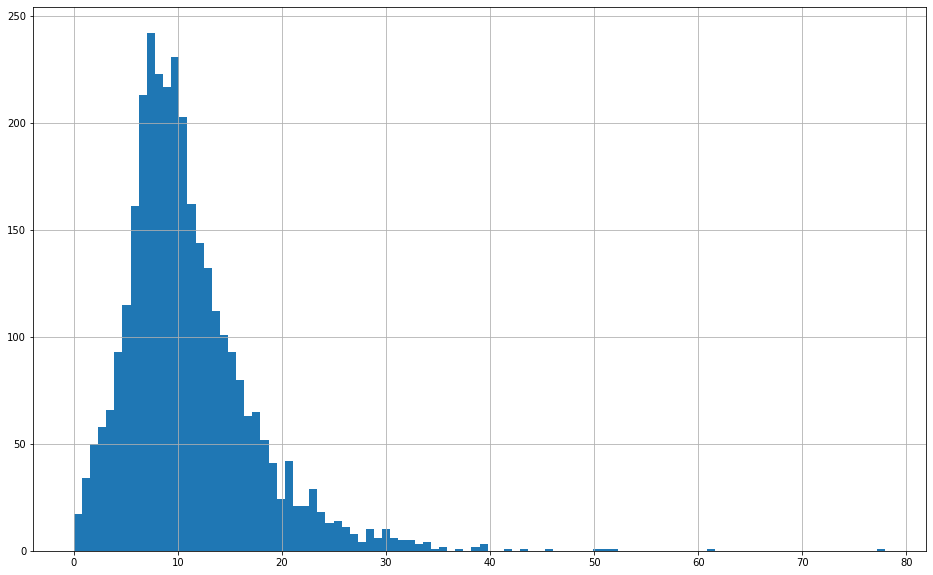

In [ ]:
data_gas['Газ 1'].hist(bins=100, figsize=(16,10))

### Результаты измерения температуры

In [ ]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.info()
data_temp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [ ]:
data_temp.tail(15)

,key,Время замера,Температура
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN


In [ ]:
len(data_temp['key'].unique())

3216

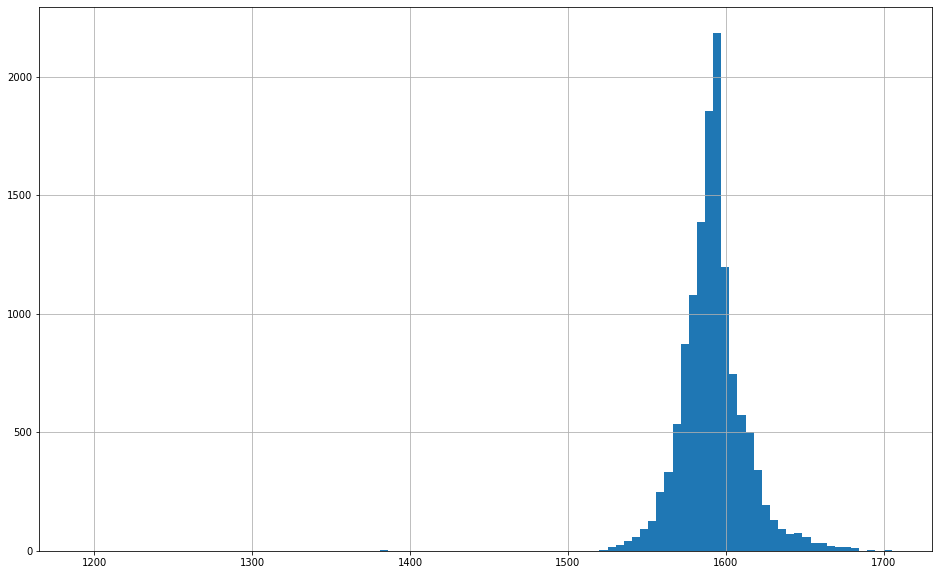

In [ ]:
data_temp['Температура'].hist(bins=100, figsize=(16,10))

Имеются пропуски ключевого признака: последней температуры, скорее всего приведет к удалению всех данных по ключу

### Данные о проволочных материалах (объём)

In [ ]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.info()
data_wire.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [ ]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(data_wire['key'].unique())

3081

### Данные о проволочных материалах (время)

In [ ]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.info()
data_wire_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [ ]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(data_wire_time['key'].unique())

3081

**Выводы:**

Имеется большие пропуски данных, скорее всего это связано с добавлением различного количество сыпучих материалов в смеси, в том числе и не добавлением, возможно это и ошибки датчика, но данные восстановить корректно невозможно.    
Во многих таблицах отсутствуют данные уникальных номеров партии 'key'.  
Есть неправильное использование типа числа с плавающей точкой, времени в формате object вместо datetime.   
Используется русскоязычные названия столбцов использование пробелов в названиях, что может приводить к ошибкам при обращении. Нужно переименовать.  
Количество записей у одной партии для каждой таблицы может различаться.  
Аномальное значение реактивной мощности в таблице data_arc.  
Данные требуют предобработки и группировки по признаку key.   
Данные распределены нормально со смещением влево  
(В графике о температуре смысла мало так как это температура на различных этапах, и этапов может быть разное количество в каждой партии)  
upd. в некоторых партиях время последнего замера температуры происходило до конца нагрева

**План решения задачи**

Целевой признак конечная температура.  
Подготовим данные.  
Создадим таблицу, где просуммируем активную и реактивную мощность для каждой партии. Это снизит вычислительную нагрузку.   
Создадим таблицу, где есть первый и последний замер температуры. (Если бы данные собирались четко по каждому этапу, то можно было бы использовать и промежуточную температуру)  
Для таблиц data_bulk и data_wire заполним пропуски нулями (предполагаем, что пропуски не являются ошибкой, а означают отсутствие подачи)  
Приведем типы данных к целочисленным для ускорения работы и временным для правильной отработки алгоритмов.  
В каждой таблице преобразуем index в значение столбца key.  
Выполним оценку мультиколлинеарности  
Разобьем данные на train/test  
Проведём обучение модели  

## Подготовка данных

### Переименуем столбцы на английский язык без пробелов

In [ ]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_gas.columns = ['key', 'gas']
data_temp.columns = ['key', 'measurement_time', 'temperature']
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [ ]:
data_arc = data_arc.query('reactive_power > 0') # Избавимся от ошибоке в данных

### Создадим таблицу, где просуммируем активную и реактивную мощность для каждой партии.

In [ ]:
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
3237,3.932467,2.828459
3238,2.106529,1.681182
3239,4.666754,3.111617


### Создадим таблицу, где есть первый и последний замер температуры.

In [ ]:
keys = []
for key in list(data_temp['key'].unique()):
    try:
        if (data_temp[data_temp['key'] == key]['measurement_time'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()): # время последнего замера температуры происходило до конца нагрева
            keys.append(key)
    except:
        keys.append(key)
data_temp = data_temp.query('key not in @keys')

In [ ]:
data_temp = data_temp.dropna() # избавимся от пропусков замеров

In [ ]:
for i in (data_temp['key'].unique()): # удаляем партии с одним замером температуры
    if (data_temp['key']==i).sum() < 2:
        data_temp = data_temp[data_temp.key != i]

In [ ]:
data_temp_time = data_temp.pivot_table(index=['key'], values=('temperature', 'measurement_time'), aggfunc=['first', 'last'])

In [ ]:
data_temp_time.columns = ['first_time', 'first_temperature', 'last_time', 'last_temperature']
data_temp_time

,first_time,first_temperature,last_time,last_temperature
key,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...
2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0


### Присваеваем индексам номер партии

In [ ]:

data_bulk = data_bulk.set_index('key')
data_gas = data_gas.set_index('key')
data_wire = data_wire.set_index('key')


### Собираем все по индексу

In [ ]:
data = pd.concat([data_temp_time, data_arc_sum, data_bulk, data_gas, data_wire], axis=1, sort=False)

In [ ]:
data

,first_time,first_temperature,last_time,last_temperature,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,4.878147,3.183241,NaN,NaN,NaN,43.0,...,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,3.052598,1.998112,NaN,NaN,NaN,73.0,...,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2.525882,1.599076,NaN,NaN,NaN,34.0,...,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,3.209250,2.060298,NaN,NaN,NaN,81.0,...,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,3.347173,2.252643,NaN,NaN,NaN,78.0,...,5.413692,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,NaN,NaN,NaN,NaN,3.932467,2.828459,NaN,NaN,170.0,NaN,...,5.543905,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3238,NaN,NaN,NaN,NaN,2.106529,1.681182,NaN,NaN,126.0,NaN,...,6.745669,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3239,NaN,NaN,NaN,NaN,4.666754,3.111617,NaN,NaN,NaN,NaN,...,16.023518,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Время замера не информативно так, как за это время происходилос разное колличество дествий
data = data.drop('first_time',axis=1)
data = data.drop('last_time',axis=1)
data = data.dropna(subset=['last_temperature'])
data = data.fillna(0)


In [ ]:
data

,first_temperature,last_temperature,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3.210690,2.360777,0.0,0.0,21.0,0.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,1554.0,1591.0,4.203064,2.810185,0.0,0.0,0.0,63.0,0.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,1571.0,1589.0,2.212379,1.851269,0.0,0.0,0.0,85.0,0.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Исправляем типы данных

In [ ]:
data['first_temperature']=data['first_temperature'].astype(int)
data['last_temperature']=data['last_temperature'].astype(int)
for i in range(1,16):
    data[f'bulk_{i}'] = data[f'bulk_{i}'].astype(int)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 29 columns):
first_temperature     2344 non-null int64
last_temperature      2344 non-null int64
sum_active_power      2344 non-null float64
sum_reactive_power    2344 non-null float64
bulk_1                2344 non-null int64
bulk_2                2344 non-null int64
bulk_3                2344 non-null int64
bulk_4                2344 non-null int64
bulk_5                2344 non-null int64
bulk_6                2344 non-null int64
bulk_7                2344 non-null int64
bulk_8                2344 non-null int64
bulk_9                2344 non-null int64
bulk_10               2344 non-null int64
bulk_11               2344 non-null int64
bulk_12               2344 non-null int64
bulk_13               2344 non-null int64
bulk_14               2344 non-null int64
bulk_15               2344 non-null int64
gas                   2344 non-null float64
wire_1                2344 non-null float64
wir

### Проведем поиск параметров с высокой корреляцией 

In [ ]:
pd.set_option('display.max_columns', None)
numeric_col = data.columns.values.tolist()

corr = data.loc[:,numeric_col].corr()
corr

,first_temperature,last_temperature,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
first_temperature,1.000000,0.366398,-0.317437,-0.301040,0.051664,0.111159,-0.125024,0.103765,0.059299,-0.122827,0.068298,-0.010111,-0.029171,0.015086,-0.080991,-0.070585,0.009501,-0.151855,-0.111719,0.009137,0.074736,-0.103741,-0.006559,0.058979,NaN,0.012919,0.041372,-0.026283,0.007762
last_temperature,0.366398,1.000000,0.247650,0.201708,-0.082638,-0.067612,-0.088806,0.061157,-0.034697,-0.188054,-0.084039,-0.021390,-0.020254,0.018222,-0.095105,0.180171,-0.012884,0.017625,0.019843,-0.025723,-0.048129,-0.215639,-0.048014,-0.121044,NaN,-0.073452,-0.100990,-0.016397,-0.039511
sum_active_power,-0.317437,0.247650,1.000000,0.960113,0.087344,0.032130,0.121613,-0.020543,0.008390,0.161418,0.075084,-0.011004,0.024766,0.015200,0.065090,0.486856,0.118707,0.462833,0.331366,0.370077,0.047404,0.041708,0.037320,0.048427,NaN,0.054877,0.020044,0.030480,-0.030722
sum_reactive_power,-0.301040,0.201708,0.960113,1.000000,0.109383,0.053517,0.081809,-0.021318,0.021516,0.154148,0.102159,-0.007875,0.012654,0.008356,0.070802,0.466969,0.112785,0.432686,0.301433,0.356356,0.022206,0.043434,0.033213,0.076913,NaN,0.057553,0.037488,0.018105,-0.020441
bulk_1,0.051664,-0.082638,0.087344,0.109383,1.000000,0.232655,-0.000914,0.041314,0.064272,0.003111,0.245377,-0.005533,-0.019094,-0.014398,-0.034034,0.320092,-0.008249,0.206012,0.015882,0.234189,0.024747,-0.005413,0.022889,0.151757,NaN,0.154920,0.086455,-0.018881,0.005714
bulk_2,0.111159,-0.067612,0.032130,0.053517,0.232655,1.000000,-0.045496,0.045181,0.360336,-0.029667,0.679366,-0.001535,-0.005299,-0.017006,0.002455,-0.096961,-0.005347,-0.134368,-0.098572,0.220772,-0.149312,-0.038428,0.223244,0.699351,NaN,0.558910,0.431743,-0.005239,-0.006841
bulk_3,-0.125024,-0.088806,0.121613,0.081809,-0.000914,-0.045496,1.000000,-0.265480,-0.004465,0.073099,-0.032245,0.021280,0.012786,-0.073089,0.002991,0.036322,-0.009336,0.036915,0.031006,0.081315,0.086518,0.094247,0.008100,-0.039323,NaN,0.009372,-0.018871,0.006266,-0.009659
bulk_4,0.103765,0.061157,-0.020543,-0.021318,0.041314,0.045181,-0.265480,1.000000,0.034548,-0.233731,0.049947,-0.012467,0.000412,-0.071456,-0.110334,0.117183,0.004931,-0.057898,0.139565,0.027941,0.317517,-0.254133,-0.034495,0.038198,NaN,-0.006277,0.035995,0.011364,-0.055342
bulk_5,0.059299,-0.034697,0.008390,0.021516,0.064272,0.360336,-0.004465,0.034548,1.000000,-0.021151,0.288370,-0.002427,-0.008377,-0.026885,-0.014955,-0.069641,-0.008453,-0.060412,-0.057913,0.090952,-0.000174,-0.012664,0.070997,0.262796,NaN,0.204887,0.172156,-0.008283,-0.010815
bulk_6,-0.122827,-0.188054,0.161418,0.154148,0.003111,-0.029667,0.073099,-0.233731,-0.021151,1.000000,-0.024812,-0.008246,-0.028458,-0.091336,0.209268,-0.094752,0.046509,0.196161,-0.074167,0.155664,-0.184598,0.192755,-0.046024,-0.025641,NaN,-0.019548,-0.012305,-0.028140,-0.017504


Высокая корреляция между sum_active_power - sum_reactive_power и bulk_9 - wire_8. Удалим по одному из столбцов.

In [ ]:
data = data.drop(['sum_reactive_power', 'wire_8'], axis=1)

### Разобьем данные

In [ ]:
features = data.drop('last_temperature', axis=1)
target = data['last_temperature']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=12345)

### Проведем оценку важности признаков

In [ ]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(features, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [ ]:
df_feature_importance = pd.DataFrame(reg.feature_importances_, index=features.columns.values, columns=['feature importance']).sort_values('feature importance', ascending=False)

In [ ]:
df_feature_importance

,feature importance
wire_1,0.308870
first_temperature,0.277892
sum_active_power,0.145447
gas,0.041078
bulk_6,0.034209
bulk_14,0.027878
wire_2,0.023918
bulk_12,0.023821
wire_6,0.022390
bulk_15,0.021935


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Отлично, что используешь эту технику. На начальном этапе моделирования мы можем генерить множество разных фич, включая и лишние. Этот инструмент, вместе с анализом мультиколлинеарности помогут нам избавиться от "балласта" 

In [ ]:
data_clean = data[list(df_feature_importance.head(13).index)]
data = pd.concat([data_clean, target], axis=1, sort=False)

In [ ]:
data

,wire_1,first_temperature,sum_active_power,gas,bulk_6,bulk_14,wire_2,bulk_12,wire_6,bulk_15,bulk_7,bulk_3,bulk_4,last_temperature
key,,,,,,,,,,,,,,
1,60.059998,1571,4.878147,29.749986,0,150,0.00000,206,0.0,154,0,0,43,1613
2,96.052315,1581,3.052598,12.555561,0,149,0.00000,206,0.0,154,0,0,73,1602
3,91.160157,1596,2.525882,28.554793,0,152,0.00000,205,0.0,153,0,0,34,1599
4,89.063515,1601,3.209250,18.841219,0,153,0.00000,207,0.0,154,0,0,81,1625
5,89.238236,1576,3.347173,5.413692,0,151,9.11456,203,0.0,152,0,0,78,1602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,89.150879,1570,3.210690,7.125735,0,129,0.00000,256,0.0,223,0,21,0,1591
2496,114.179527,1554,4.203064,9.412616,0,129,0.00000,256,0.0,226,0,0,63,1591
2497,94.086723,1571,2.212379,6.271699,0,124,9.04800,230,0.0,226,0,0,85,1589


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
ок

### Проведем поиск аномалий.
Для этого воспользуемся простым алгоритмом классификации  
Без этого MSE до идеала не доводилось

In [ ]:
model = KNN()
data_anomaly = data
model.fit(data_anomaly)
data_anomaly['anomaly'] =  model.predict(data_anomaly) == 1
anomaly_indexes = list(data_anomaly[data_anomaly['anomaly'] == 1].index)
data_knn = data.drop(anomaly_indexes)

In [ ]:
len(anomaly_indexes)

207

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
хорошо. С выбросами тут действительно важный момент. Ведь выброс выбросу рознь) Бывает, что выброс - то реальная бизнес-практика. И если удалить их, то мы получим модель, так скажем, работующую не во всех диапазонах входящих в неё факторов. Т.е. по метрикам модель будет хорошая. А вот по бизнесу - не совсем применимая.<br>А бывают выбросы - точно выбросы - ошибки учёта данных, например.<br>
    
В самой теории выбросов принято считать, что выбросы в интервале от q_3 + 1.5*irq до q_3 + з*irq - на усмотрение бизнеса. А вот всё, что больше q_3 + 3*irq - уже точно надо работать - на удаление!!!<br>
q_3 - верхняя квартиль<br>
irq - интерквартильный размах

В таких проектах, также лучше использовать такую философию анализа выбросов:<br>
Ящик с усами - даёт пищу для размышлений (не более того, не воспринимаем его как сигнал к действию).<br>
А потом смотрим то явление, что изучаем. Данные значения - могут быть в реальности или нет?<br>
Вот, например, с температурой плавления: по справочнику она у металла = около 1400+-, т.е. 1200 - действиетльно кажется очень странным значением.

In [ ]:
### Повторно разобьем важные выборки без аномалий

In [ ]:
features = data_knn.drop('last_temperature', axis=1)
target = data_knn['last_temperature']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=12345)

## Обучение модели

### LinearRegression

In [ ]:
%%time
regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

MAE LinearRegression = 7.386064722124121
CPU times: user 97.5 ms, sys: 48.6 ms, total: 146 ms
Wall time: 396 ms


### RandomForestRegressor

In [ ]:
%%time
regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 200, 10)], 
                'random_state':[12345]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Перебор параметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1), params))
print()
cv_MAE_RFR = (max(means)*-1)
print()
print("Лучшие параметры")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)


Перебор параметров:

6.0949 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 12345}
6.0896 for {'criterion': 'mse', 'n_estimators': 110, 'random_state': 12345}
6.0907 for {'criterion': 'mse', 'n_estimators': 120, 'random_state': 12345}
6.0942 for {'criterion': 'mse', 'n_estimators': 130, 'random_state': 12345}
6.0819 for {'criterion': 'mse', 'n_estimators': 140, 'random_state': 12345}
6.0795 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 12345}
6.0790 for {'criterion': 'mse', 'n_estimators': 160, 'random_state': 12345}
6.0753 for {'criterion': 'mse', 'n_estimators': 170, 'random_state': 12345}
6.0774 for {'criterion': 'mse', 'n_estimators': 180, 'random_state': 12345}
6.0809 for {'criterion': 'mse', 'n_estimators': 190, 'random_state': 12345}


Лучшие параметры

{'criterion': 'mse', 'n_estimators': 170, 'random_state': 12345}
CPU times: user 1min 31s, sys: 381 ms, total: 1min 31s
Wall time: 9min 9s


### CatBoostRegressor 

In [ ]:
%%time
regressor = CatBoostRegressor(verbose=False, random_state=12345)
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE CatBoostRegressor =', cv_MAE_CBR)
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=12345).fit(features_train, 
                                        target_train).get_all_params()

MAE CatBoostRegressor = 5.801056530668292
CPU times: user 1min 40s, sys: 12.9 s, total: 1min 53s
Wall time: 5min 42s


### LGBMRegressor

In [ ]:
%%time
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(10,15)], 
                'learning_rate':[0.05, 0.07, 0.9],
                'random_state':[12345]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1), params))
print()
cv_MAE_LGBMR = (max(means)*-1)
print()
print("Лучшие параметры:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)


Grid scores on development set:

6.0413 for {'learning_rate': 0.05, 'num_leaves': 10, 'random_state': 12345}
6.0468 for {'learning_rate': 0.05, 'num_leaves': 11, 'random_state': 12345}
6.0674 for {'learning_rate': 0.05, 'num_leaves': 12, 'random_state': 12345}
6.0379 for {'learning_rate': 0.05, 'num_leaves': 13, 'random_state': 12345}
6.0400 for {'learning_rate': 0.05, 'num_leaves': 14, 'random_state': 12345}
6.0004 for {'learning_rate': 0.07, 'num_leaves': 10, 'random_state': 12345}
5.9955 for {'learning_rate': 0.07, 'num_leaves': 11, 'random_state': 12345}
6.0346 for {'learning_rate': 0.07, 'num_leaves': 12, 'random_state': 12345}
6.0338 for {'learning_rate': 0.07, 'num_leaves': 13, 'random_state': 12345}
6.0043 for {'learning_rate': 0.07, 'num_leaves': 14, 'random_state': 12345}
7.7257 for {'learning_rate': 0.9, 'num_leaves': 10, 'random_state': 12345}
7.8109 for {'learning_rate': 0.9, 'num_leaves': 11, 'random_state': 12345}
7.8907 for {'learning_rate': 0.9, 'num_leaves': 12, 'rand

### XGBRegressor

In [ ]:
%%time
regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[x/100 for x in range(8, 19)],
                'random_state':[12345],
                 'silent':[True]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Перебор параметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
cv_MAE_XGBR = (max(means)*-1)
print()
print("Лучшие параметры:")
print()
best_params_XGBR = clf.best_params_
print(clf.best_params_)


Перебор параметров:

5.974038 for {'learning_rate': 0.08, 'random_state': 12345, 'silent': True}
5.978871 for {'learning_rate': 0.09, 'random_state': 12345, 'silent': True}
5.929323 for {'learning_rate': 0.1, 'random_state': 12345, 'silent': True}
5.907650 for {'learning_rate': 0.11, 'random_state': 12345, 'silent': True}
5.929109 for {'learning_rate': 0.12, 'random_state': 12345, 'silent': True}
5.960201 for {'learning_rate': 0.13, 'random_state': 12345, 'silent': True}
5.899708 for {'learning_rate': 0.14, 'random_state': 12345, 'silent': True}
5.967490 for {'learning_rate': 0.15, 'random_state': 12345, 'silent': True}
5.954298 for {'learning_rate': 0.16, 'random_state': 12345, 'silent': True}
5.967511 for {'learning_rate': 0.17, 'random_state': 12345, 'silent': True}
6.022010 for {'learning_rate': 0.18, 'random_state': 12345, 'silent': True}


Лучшие параметры:

{'learning_rate': 0.14, 'random_state': 12345, 'silent': True}
CPU times: user 6.9 s, sys: 35 ms, total: 6.93 s
Wall time: 

## Тестирование моделей

### LinearRegression

In [ ]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_LR = mean_absolute_error(target_predict, target_test)
print('MAE LinearRegression =', test_MAE_LR)

MAE LinearRegression = 7.255499346104336
CPU times: user 9.2 ms, sys: 4.17 ms, total: 13.4 ms
Wall time: 6.94 ms


### RandomForestRegressor 

In [ ]:
%%time
model = RandomForestRegressor()
model.set_params(**best_params_RFR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_RFR = mean_absolute_error(target_predict, target_test)
print('MAE RandomForestRegressor =', test_MAE_RFR)

MAE RandomForestRegressor = 6.073655854865305
CPU times: user 1.87 s, sys: 0 ns, total: 1.87 s
Wall time: 1.88 s


### CatBoostRegressor

In [ ]:
%%time
model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('MAE CatBoostRegressor =', test_MAE_CBR)

MAE CatBoostRegressor = 5.783574768967808
CPU times: user 14.8 s, sys: 1.86 s, total: 16.6 s
Wall time: 18 s


### LGBMRegressor

In [ ]:
%%time
model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_LGBMR = mean_absolute_error(target_predict, target_test)
print('MAE LGBMRegressor =', test_MAE_LGBMR)

MAE LGBMRegressor = 5.869303560555954
CPU times: user 104 ms, sys: 4 ms, total: 108 ms
Wall time: 106 ms


### XGBRegressor

In [ ]:
%%time
model = XGBRegressor()
model.set_params(**best_params_XGBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_XGBR = mean_absolute_error(target_predict, target_test)
print('MAE XGBRegressor =', test_MAE_XGBR)

MAE XGBRegressor = 5.939242753358645
CPU times: user 151 ms, sys: 0 ns, total: 151 ms
Wall time: 157 ms


## Вывод

Лучшая модель CatBoostRegressor, MAE = 5.79  
Другие модели так же дают хороший результат и могут использоваться для предсказаний.  
Для улучшения метрики использовали оценку важности гиперпараметров и поиск аномалий.
